# Learning Graph Representations

## Network and Vertex feature joint representation learning

In many network problems, you might have access to much more information than just the 
collection of nodes and edges in the network. If you were investigating a social 
network, for instance, you might have access to extra information about each 
person -- their gender, for instance, or their age. When we you embed a network, it seems 
like you should be able to use this information - called "features" or "covariates" - to somehow improve your analysis.
Many of the techniques and tools that we'll explore in this section use both the covariates and the network to 
learn from new, holistic representations of the data available to us, jointly using both the network and the covariates.
These techniques are called joint representation learning.

There are two primary reasons that we might want to explore using node covariates in addition to networks. Firstly, they might improve our 
standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. 
For example, if the latent structure of the covariates lines up with the latent structure
of our network, then we could conceivably reduce noise, even if they don't overlap perfectly. Second,
figuring out what the clusters of an embedding actually mean can sometimes be difficult, and using covariates
gives us to access to a natural structure. If we're clustering brain networks, for instance, 
covariate information telling us a location in the brain and name of brain region for each node might let us better
cluster by region.

#### Generating Data

We need a graph and some covariates. To start off, we'll make a pretty straightforward Stochastic Block Model with 1500 nodes and 3 communities.

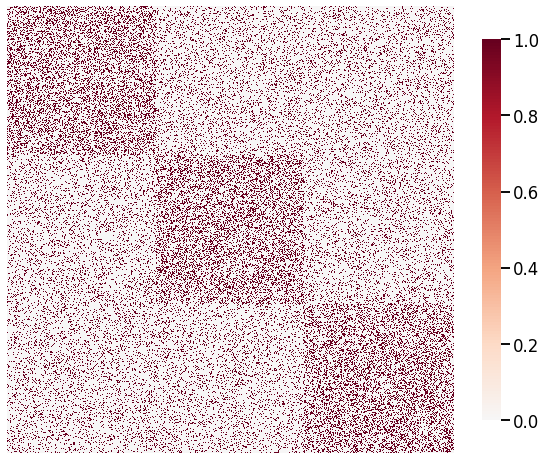

In [54]:
import numpy as np
from graspologic.simulations import sbm
from graspologic.plot import heatmap
import warnings
warnings.filterwarnings("ignore")  # TODO: don't do this, fix scatterplot

# Start with some simple parameters
N = 1500
n = N // 3
p, q = .3, .15
B = np.array([[p, q, q],
              [q, p, q],
              [q, q, p]])

# Make our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)
heatmap(A);

Now, let's generate some covariates. Remember, each node is associated with its own group of covariates that provide information about the node. We'll organize these into a matrix, where each row contains the covariates associated with a particular node.  

To keep things simple, we'll have our covariates only take on true/false values - or, more specifically, 0 and 1. We'd also like a node's covariates to look different depending on which community it belongs to. To that end, we'll give each node 30 covariates, with the first 10 having a higher probability of 1 in the first community, the second having a higher probability of 1 in the second community, and the third having a higher probability of 1 in the third community.

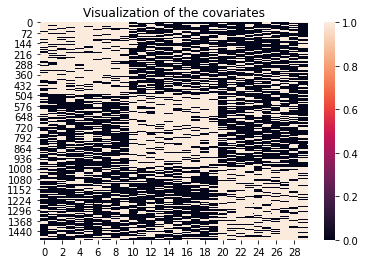

In [55]:
import numpy as np
from scipy.stats import bernoulli
import seaborn as sns

def gen_covariates(p1=.8, p2=.3, N=1500):
    """
    Generate a matrix of covariates.
    """
    n_covariates = 30

    bern = lambda p: bernoulli.rvs(p, size=(N//3, n_covariates//3))    
    X = np.block([[bern(p1), bern(p2), bern(p2)],
                  [bern(p2), bern(p1), bern(p2)],
                  [bern(p2), bern(p2), bern(p1)]])

    return X

X = gen_covariates(N=N)
ax = sns.heatmap(X)
ax.set_title("Visualization of the covariates");

### Covariate-Assisted Spectral Embedding

<i>Covariate-Assisted Spectral Embedding</i>, or CASE<sup>1</sup>, is a simple way of combining our graph and our covariates into a single model. In the most straightforward version of CASE, we use the graph's regularized Laplacian matrix $L$ and a function of our covariate matrix $XX^T$ (where $X$ is just our covariate matrix, in which row $i$ contains the covariates associated with node $i$).  

Remember that, in our case, $X$ only contains 0's and 1's. To interpret $XX^T$, remember from linear algebra that we're taking the weighted sum (or, in math parlance, the dot product) of each row with each other row, as shown below:

**NOTE:: TEMPORARY, MAKE A BETTER EXPLANATORY FIGURE**

\begin{align}
\begin{bmatrix}
1 \\
0 \\
1 \\
\end{bmatrix} \times 
\begin{bmatrix}
0 \\
1 \\
1 \\
\end{bmatrix} =
\begin{bmatrix}
0 \\
0 \\
1 \\
\end{bmatrix}
\end{align}

**NOTE:: the below explanation might be more technical than we want?**

If there are two overlapping 1's in the same place in rows $i$ and $j$, then their weighted sum will have a 1 in that place. The resulting value, $XX^T_{i, j}$ will be equal to the number of positions in which rows $i$ and $j$ both have ones. So, a position of $XX^T$ can be interpreted as measuring the "agreement" between rows $i$ and row $j$. The result is a matrix that looks fairly similar to our Laplacian!  

The following Python code generates both matrices and visualizes them.

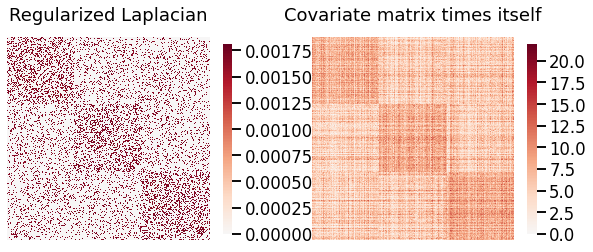

In [69]:
from graspologic.utils import to_laplacian
import matplotlib.pyplot as plt

L = to_laplacian(A, form="R-DAD")
XXt = X@X.T

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
heatmap(L, title=r"Regularized Laplacian", ax=axs[0])
heatmap(XXt, title="Covariate matrix times itself", ax=axs[1]);

CASE simply sums these two matrices together, using a weight for $XX^T$ so that they both contribute equally to the result.

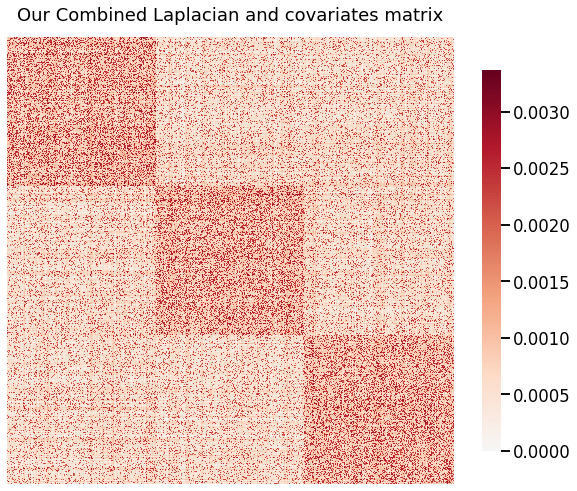

In [70]:
top_eigval_L = np.linalg.eigvalsh(LL)[-1]
top_eigval_XXt = np.linalg.eigvalsh(XXt)[-1]
alpha = np.float(top_eigval_L / top_eigval_XXt)

L_ = L + alpha * X@X.T
heatmap(L_, title="Our Combined Laplacian and covariates matrix");

Everything works as usual from there: we decompose our matrix using an SVD, extracting the first two eigenvectors, and then plot the rows to visualize our clustering.

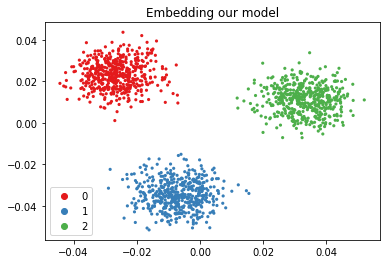

In [71]:
from graspologic.embed import selectSVD
from graspologic.plot import pairplot

def plot_latents(latent_positions, title):
    plot = sns.scatterplot(latent_positions[:, 1], latent_positions[:, 2], 
                           hue=labels, palette="Set1", linewidth=0, s=10)
    plot.set_title(title);
    

latents, D, V = selectSVD(L_, n_components=3, algorithm="full")
plot_latents(latents, "Embedding our model")

#### Using Graspologic

Graspologic's CovariateAssistedSpectralEmbedding class uses SVD decomposition to implement CASE, just like we just did earlier. The following code applies CASE to reduce the dimensionality of $L + aXX^T$ down to three dimensions, and then plots the second dimension against the third to show the clustering.

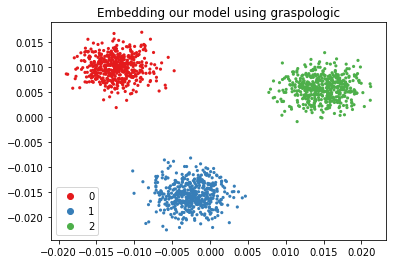

In [72]:
from graspologic.embed import CovariateAssistedEmbedding as CASE

casc = CASE(embedding_alg="assortative", n_components=3)
latents = casc.fit_transform(A, covariates=X)
plot_latents(latents, "Embedding our model using graspologic")

#### References

[1] N. Binkiewicz, J. T. Vogelstein, K. Rohe, Covariate-assisted spectral clustering, Biometrika, Volume 104, Issue 2, June 2017, Pages 361–377, https://doi.org/10.1093/biomet/asx008